In [1]:
# 107062566 CVLab 黃鈺程
# Requirements: numpy, matplotlib, tqdm, tensorflow

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf

In [3]:
xor_data = np.array([[1, 0],[0, 1], [1, 1], [0, 0]])
xor_label = np.array([[1], [1], [0], [0]])


W1 :
[[ 3.2 -3. ]
 [-2.1 -1.5]]
b1 :
[-2.5  3.9]
W2 :
[[2.9]
 [2.9]]
b2 :
[-0.1]


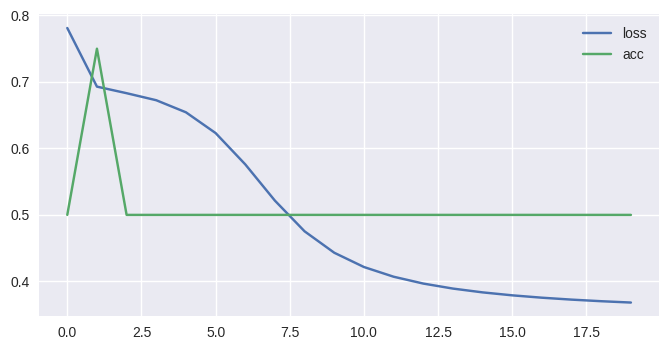

In [4]:
tf.reset_default_graph()

with tf.Graph().as_default() as g:
    with tf.name_scope('data'):
        x = tf.placeholder(tf.float32, [None, 2])
        y = tf.placeholder(tf.float32, [None, 1])
    
    with tf.name_scope('model'):
        W1 = tf.Variable(tf.random_uniform([2, 2], -1, 1))
        b1 = tf.Variable(tf.random_uniform([2]))
        W2 = tf.Variable(tf.random_uniform([2, 1], -1, 1))
        b2 = tf.Variable(tf.random_uniform([1]))
        
        z1 = tf.nn.tanh((x @ W1) + b1)
        z2 = tf.nn.sigmoid((z1 @ W2) + b2)
        p = z2
    
    with tf.name_scope('loss'):
        loss = -tf.reduce_mean(y * tf.log(p) + (1 - y) * tf.log(1 - p))
        
    with tf.name_scope('optim'):
        optim = tf.train.GradientDescentOptimizer(1e-2).minimize(loss)
        
    with tf.name_scope('acc'):
        eq = tf.equal(tf.round(p), y)
        acc = tf.reduce_mean(tf.cast(eq, tf.float32))
        
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    
    loss_history = []
    acc_history = []
    for i in tqdm(range(20000)):
        l, a, _ = sess.run([loss, acc, optim], feed_dict={x:xor_data, y:xor_label})
        if i % 1000 == 0:
            loss_history.append(l)
            acc_history.append(a)
    
    ns = ['W1', 'b1', 'W2', 'b2']
    ws = sess.run([W1, b1, W2, b2], feed_dict={x:xor_data, y:xor_label})
    np.set_printoptions(precision=1)
    for n, w in zip(ns, ws):
        print(n, ':')
        print(w)
        
fig, ax = plt.subplots(dpi=100, figsize=(8, 4))
ax.plot(np.arange(len(loss_history)), loss_history, '-', label='loss')
ax.plot(np.arange(len(acc_history)), acc_history, '-', label='acc')
ax.legend()
plt.show()

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.data import Dataset
mnist = input_data.read_data_sets("data/mnist", one_hot=True)
n_train = mnist.train.images.shape[0]
n_valid = mnist.validation.images.shape[0]
n_test = mnist.test.images.shape[0]

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/mnist/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/mnist/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [6]:
tf.reset_default_graph()

def accuracy(p, y):
    p = tf.argmax(p, 1)
    y = tf.argmax(y, 1)
    c = tf.equal(p, y)
    return tf.reduce_mean(tf.cast(c, tf.float32))

def cross_entropy(p, y):
    return -tf.reduce_mean(tf.cast(y, tf.float32) * tf.log(p))


class FC:
    def __init__(self, inc, outc, name):
        self.name = name
        with tf.name_scope(name):
            self.W = tf.Variable(tf.random_uniform([inc, outc], -1, 1))
            self.b = tf.Variable(tf.random_uniform([outc], -1, 1))

    def __call__(self, x):
        return x @ self.W + self.b


class MyModel:
    def __init__(self):
        self.fc1 = FC(28*28, 256, 'fc1')
        self.fc2 = FC(256, 64, 'fc2')
        self.fc3 = FC(64, 10, 'fc3')

    def __call__(self, x):
        z1 = tf.nn.sigmoid(self.fc1(x))
        z2 = tf.nn.sigmoid(self.fc2(z1))
        z3 = tf.nn.softmax(self.fc3(z2), 1)
        return z3

    
with tf.Graph().as_default() as g:
    train_set = Dataset.from_tensor_slices((mnist.train.images, mnist.train.labels))
    train_set = train_set.batch(128)
    train_iter = train_set.make_initializable_iterator()
    train_img, train_lbl = train_iter.get_next()

    valid_set = Dataset.from_tensor_slices((mnist.validation.images, mnist.validation.labels))
    valid_set = valid_set.batch(128)
    valid_iter = valid_set.make_initializable_iterator()
    valid_img, valid_lbl = valid_iter.get_next()

    test_set = Dataset.from_tensor_slices((mnist.test.images, mnist.test.labels))
    test_set = test_set.batch(128)
    test_iter = test_set.make_initializable_iterator()
    test_img, test_lbl = test_iter.get_next()
    
    
    x = tf.placeholder(tf.float32, [None, 784])
    y = tf.placeholder(tf.float32, [None, 10])
    
    m = MyModel()
    p = m(x)
    
    loss = cross_entropy(p, y)
    acc = accuracy(p, y)
    optim = tf.train.AdamOptimizer(1e-2).minimize(loss)
    
        
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())

    def train():
        losses, accs = [], []
        while True:
            try:
                img_, lbl_ = sess.run([train_img, train_lbl])
                loss_, acc_, _ = sess.run([loss, acc, optim], feed_dict={x:img_, y:lbl_})
                losses.append(loss_)
                accs.append(acc_)
            except tf.errors.OutOfRangeError:
                break
        avg_loss = np.mean(np.float32(losses))
        avg_acc = np.mean(np.float32(accs))
        return avg_loss, avg_acc
    
    def valid():
        losses, accs = [], []
        while True:
            try:
                img_, lbl_ = sess.run([valid_img, valid_lbl])
                loss_, acc_ = sess.run([loss, acc], feed_dict={x:img_, y:lbl_})
                losses.append(loss_)
                accs.append(acc_)
            except tf.errors.OutOfRangeError:
                break
        avg_loss = np.mean(np.float32(losses))
        avg_acc = np.mean(np.float32(accs))
        return avg_loss, avg_acc
    
    def test():
        losses, accs = [], []
        while True:
            try:
                img_, lbl_ = sess.run([test_img, test_lbl])
                loss_, acc_ = sess.run([loss, acc], feed_dict={x:img_, y:lbl_})
                losses.append(loss_)
                accs.append(acc_)
            except tf.errors.OutOfRangeError:
                break
        avg_loss = np.mean(np.float32(losses))
        avg_acc = np.mean(np.float32(accs))
        return avg_loss, avg_acc
        

    history = []
    for epoch in range(10):
        sess.run(train_iter.initializer)
        sess.run(valid_iter.initializer)
        
        train_loss_, train_acc_ = train()
        valid_loss_, valid_acc_ = valid()
        history.append({
            'epoch': epoch,
            'train_loss': '{:.4f}'.format(train_loss_),
            'train_acc': '{:.4f}'.format(train_acc_),
            'valid_loss': '{:.4f}'.format(valid_loss_),
            'valid_acc': '{:.4f}'.format(valid_acc_)
        })
        print(history[-1])
    
    sess.run(test_iter.initializer)
    test_loss, test_acc = test()
    print('Test Loss:', test_loss)
    print('Test Acc:', test_acc)

{'epoch': 0, 'train_loss': '0.0365', 'train_acc': '0.8945', 'valid_loss': '0.0198', 'valid_acc': '0.9414'}
{'epoch': 1, 'train_loss': '0.0151', 'train_acc': '0.9549', 'valid_loss': '0.0151', 'valid_acc': '0.9549'}
{'epoch': 2, 'train_loss': '0.0108', 'train_acc': '0.9674', 'valid_loss': '0.0136', 'valid_acc': '0.9609'}
{'epoch': 3, 'train_loss': '0.0082', 'train_acc': '0.9744', 'valid_loss': '0.0123', 'valid_acc': '0.9641'}
{'epoch': 4, 'train_loss': '0.0070', 'train_acc': '0.9780', 'valid_loss': '0.0133', 'valid_acc': '0.9607'}
{'epoch': 5, 'train_loss': '0.0059', 'train_acc': '0.9808', 'valid_loss': '0.0114', 'valid_acc': '0.9684'}
{'epoch': 6, 'train_loss': '0.0054', 'train_acc': '0.9824', 'valid_loss': '0.0119', 'valid_acc': '0.9660'}
{'epoch': 7, 'train_loss': '0.0055', 'train_acc': '0.9820', 'valid_loss': '0.0127', 'valid_acc': '0.9662'}
{'epoch': 8, 'train_loss': '0.0053', 'train_acc': '0.9827', 'valid_loss': '0.0131', 'valid_acc': '0.9631'}
{'epoch': 9, 'train_loss': '0.0049', 

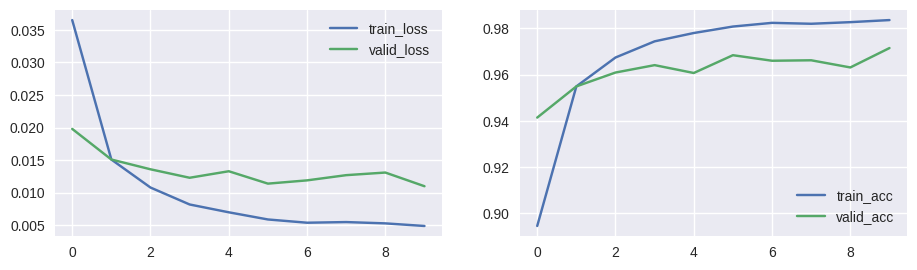

In [7]:
fig, ax = plt.subplots(1, 2, dpi=100, figsize=(11, 3))
xs = [item['epoch'] for item in history]
for c in ['train_loss', 'valid_loss']:
    ys = [float(item[c]) for item in history]
    ax[0].plot(xs, ys, '-', label=c)
ax[0].legend()
for c in ['train_acc', 'valid_acc']:
    ys = [float(item[c]) for item in history]
    ax[1].plot(xs, ys, '-', label=c)
ax[1].legend()
plt.show()